In [1]:
import resreg
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import shap
from xgboost import XGBRegressor, DMatrix
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


  Val set r2: 0.898985010923183
  Val set rmse: 6.016104603517936
  training set r2: 0.8891102040248395
  training set rmse: 3.619947377430976


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
59it [00:13,  1.23it/s]                        


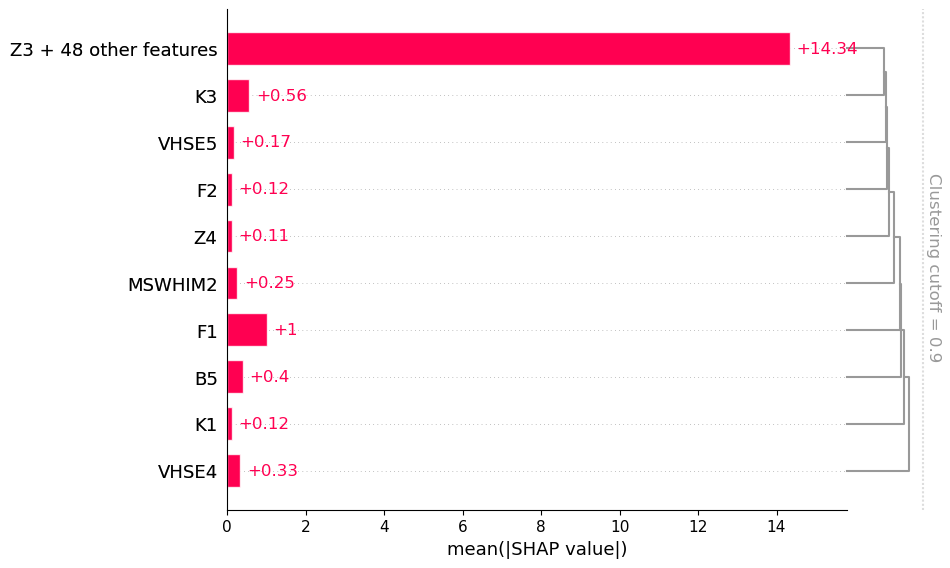

In [2]:
### train the best XGBoost model

def customMSE(dtrain: DMatrix, predt: np.ndarray) -> Tuple[str, float]:
    ''' Mean squared error '''
    # actual, predicted
    return mean_squared_error(dtrain, predt)


if __name__ == "__main__":
    # import data
    dfInput = pd.read_csv("All_Input_.tsv", sep="\t", header=0)
    filter_col = [i for i in dfInput.columns if i.endswith("mean")]
    X = dfInput[filter_col]
    X.columns = X.columns.str.replace("_mean","")
    y = dfInput["Temp"]

    # import file with optimal hyperparameters
    with open("params.tsv", 'r') as f:
        lines = f.readlines()
        params = [line.replace("\n", "").split("\t") for line in lines]

    for i in range(1,2):
        random_state = 3
        paramset = params[i]
        
        # split data into training, test and validation set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
        X_train, X_valTot, y_train, y_valTot = train_test_split(X_train, y_train, test_size=0.11,
                                                                    random_state=random_state)  # 0.25 x 0.8 = 0.2

        # rebalance the validation set
        y_valExt = y_valTot[(y_valTot > 40) | (y_valTot < 22)]
        y_mes = y_valTot[(y_valTot < 40) & (y_valTot > 22)]
        minlen = min(len(y_valExt), len(y_mes))
        y_val = pd.concat([y_valExt[0:minlen], y_mes[0:minlen]])
        X_val = X_valTot.loc[y_val.index]

        # import the hyperparameters
        max_depth = int(paramset[0])
        learning_rate = float(paramset[1])
        n_estimators = int(paramset[2])
        min_child_weight = int(paramset[3])
        gamma = float(paramset[4])
        subsample = float(paramset[5])
        reg_lambda = float(paramset[6])

        # define and train the XGBoost model
        opt_model = XGBRegressor(max_depth = max_depth, learning_rate  = learning_rate, n_estimators = n_estimators,
                                 min_child_weight = min_child_weight, gamma = gamma, subsample = subsample,
                                 reg_lambda = reg_lambda, eval_metric = customMSE, early_stopping_rounds = 10)

        opt_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
                      verbose=False)

        # get the predictions on the validation and test set
        y_valpred = opt_model.predict(X_val)
        y_pred = opt_model.predict(X_test)

        # get the SHAP values
        explainer = shap.TreeExplainer(opt_model)
        shap_values = explainer.shap_values(X_test)

        # create the SHAP clustering
        clustering = shap.utils.hclust(X_test, y_test)  # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
        plt.tight_layout()
        shap.plots.bar(explainer(X_test), clustering=clustering,
                       clustering_cutoff=0.9)
        
        plt.show()




In [3]:
# create a dataframe with two columns: predicted and actual temperatures 
y_pred2 = pd.DataFrame(y_pred, columns = ["Predicted"])
y_test2 = y_test.reset_index(drop = False)
y_test2["Predicted"] = y_pred2["Predicted"]
y_test2["Diff"] = y_test2["Predicted"] - y_test2["Temp"]

In [7]:
import seaborn as sns

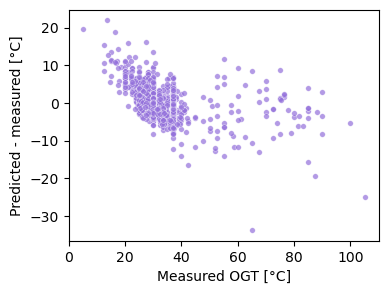

In [9]:
# plot the difference
sns.scatterplot(x = y_test2["Temp"], y = y_test2["Diff"], s = 16, color = "mediumpurple", alpha = 0.7)
plt.xlabel("Measured OGT [°C]")
plt.ylabel("Predicted - measured [°C]")
fig = plt.gcf()
fig.set_size_inches(4,3)

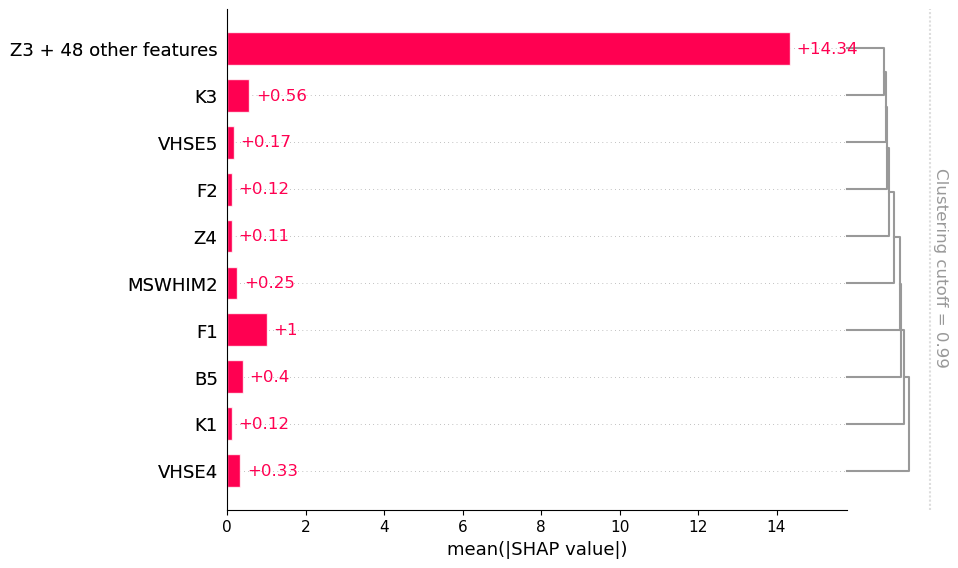

In [4]:
 # plot clustering with absolute mean SHAP values
shap.plots.bar(explainer(X_test), clustering=clustering,
                       clustering_cutoff=0.99)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


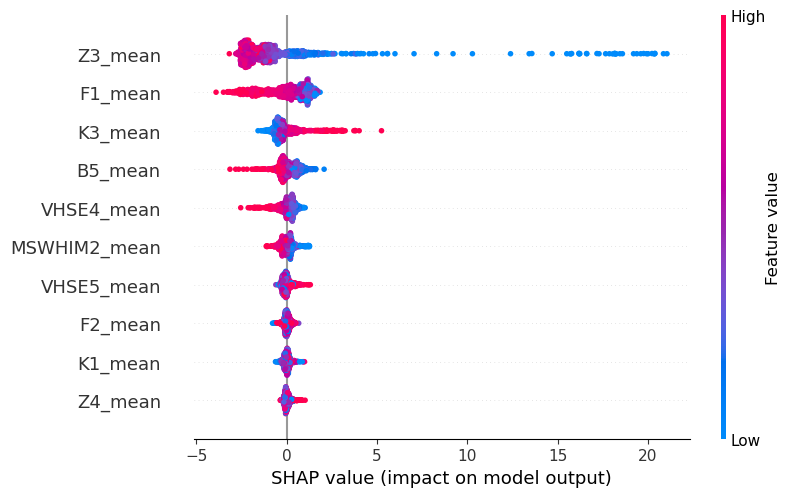

In [29]:
# create the beeswarm plot of some of the descriptors
shap.plots.beeswarm(explainer(X_test)[:,[0,2,27,35, 36, 39,44,45,49,50]])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


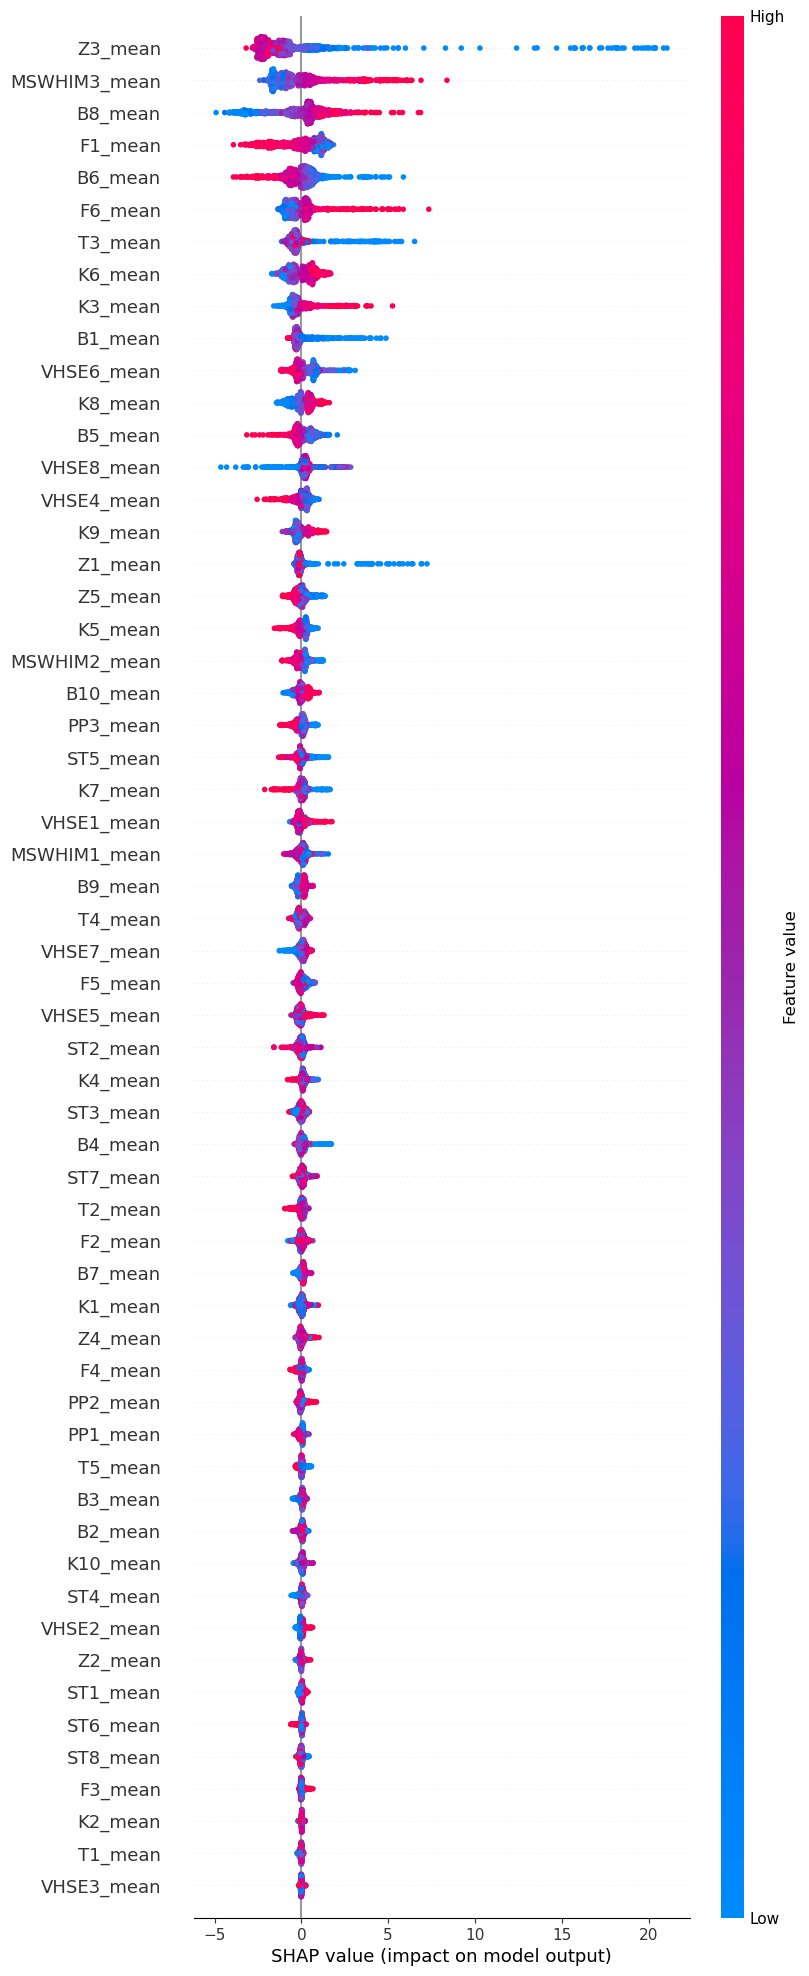

In [7]:
# create the beeswarm plot of all descriptors
shap.plots.beeswarm(explainer(X_test), max_display=58)

In [10]:
print(filter_col.index("F6_mean"))

54


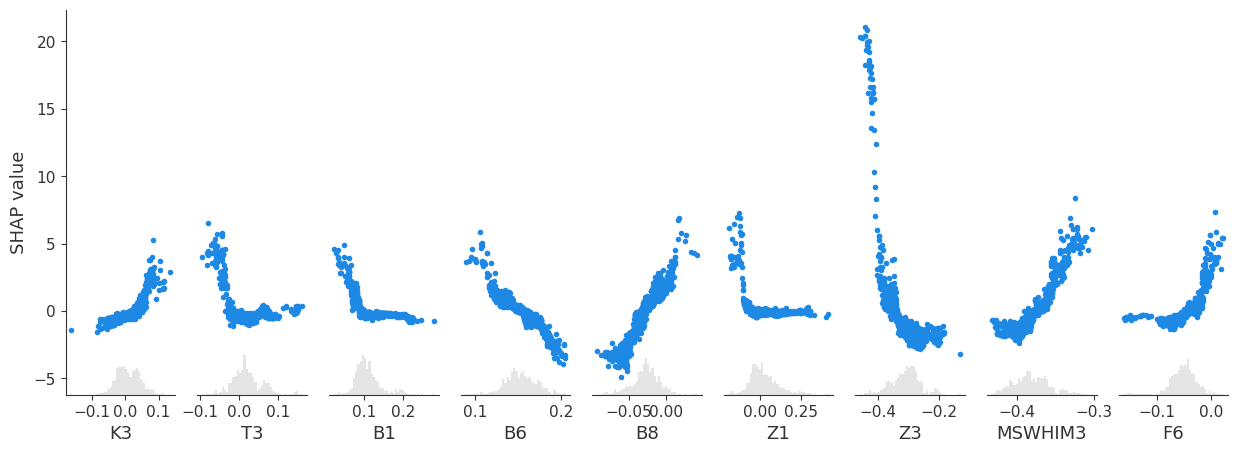

In [11]:
# create scatterplots of some descriptors
shap.plots.scatter(explainer(X_test)[:,[2, 12, 23, 28, 30, 33, 35, 40, 54]])

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(X_test)
shap.summary_plot(shap_interaction_values, X_test)

In [34]:
print(shap_interaction_values.shape)

(1089, 58, 58)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


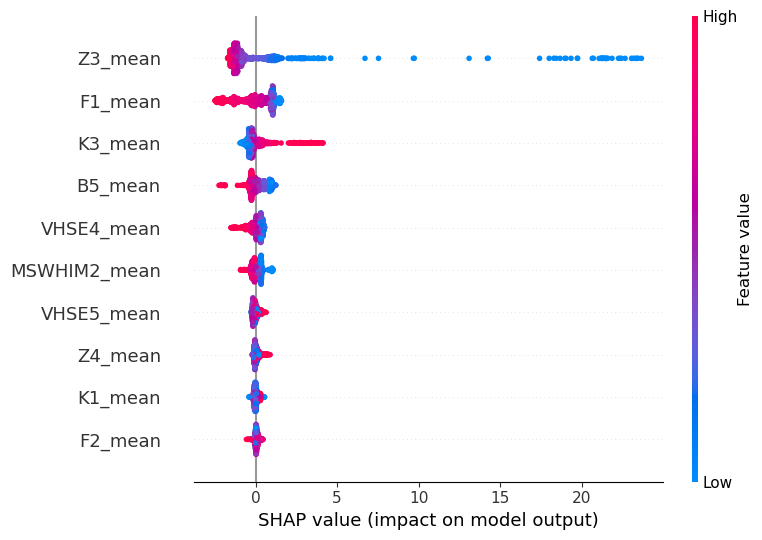

In [35]:
shap.summary_plot(shap_interaction_values[:,[0,2,27,35, 36, 39,44,45,49,50],[0,2,27,35, 36, 39,44,45,49,50]], 
                  X_test.iloc[:,[0,2,27,35, 36, 39,44,45,49,50]])